**Probability is the mathematics of reasoning under uncertainty, much as calculus is the mathematics for reasoning about rates of change.** Models built in the language of probability can capture complex reasoning, know what they do not know, and uncover structure in data without supervision. Further, probability provides a way for human experts to provide knowledge to AI systems in the form of a priori beliefs.



By observing the outcome of a probabilistic program, we can describe an inference problem, roughly translated as: “**what must be true if this random choice had a certain observed value?**” Probabilistic programming systems provide universal inference algorithms that can perform inference with little intervention from the user. 

Yet **inference is the key challenge for probabilistic modeling**, and non-scalable inference is the main failure mode of PPLs. Leveraging the power of deep learning, recent advances have introduced a new approach to probabilistic inference and PPL implementation. **The key idea is to describe inference in a model via a second model called an inference model, or guide in Pyro.** (This is actually an idea that goes back as far as at least the Helmholtz machine.) Just as **a model is a generative story for the data, a guide is a generative story for translating the data into latent choices**.

Of course, **we cannot simply write down the correct guide** (that is why inference is hard). **Instead, we use the variational approach, specifying a parameterized family of guides and then solving an optimization problem to move the guide toward the posterior distribution of the model.** This **optimization can be automated thanks to automatic differentiation**, a technique for efficiently computing the gradient of a program, and several tricks for estimating the gradient of an expectation.

 

The basic operations in a PPL are sampling from a distribution, observing sampled values, and inferring the resulting posterior over executions. However, the required behavior of sampling statements depends on the inference context in which they occur. For instance, when computing the standard evidence-lower-bound objective, sampling statements in the guide should actually sample new values, while sampling statements in the model should only reuse these values. **The Pyro implementation builds these context-specific effects out of a set of Poutine objects (a tasty portmanteau for Pyro Coroutine), such as Trace, Replay, and Condition. Each Poutine provides a small modification to the handling of Pyro constructs (sampling, parameter construction, etc); layering Poutines together allows us to build the operations needed for different inference algorithms. **With this program logic handled by Poutines, the main inference code focuses on constructing objectives and estimating gradients.

Ref: https://colab.research.google.com/drive/1FvNCbnu16evlCXyxxzNPf1uHUkVkDSFJ#scrollTo=g3gdg3buYOoI

# Introduction to pyro
**An Introduction to Models in Pyro**

The basic unit of probabilistic programs is the stochastic function. 
It has two parts:

1. Deterministic Python code.
2. Primitive stochastic functions that call a random number generator.

In [4]:
!pip install pyro-ppl

     |████████████████████████████████| 471kB 7.6MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 753.4MB 16kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [0]:
import seaborn as sns
import pyro 
from pyro import condition
from pyro.poutine import trace
from pyro.infer import NUTS, MCMC, EmpiricalMarginal
import pyro.distributions as dist
from pyro import param
import torch
from torch.distributions import constraints
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)

# Introduction to distributions using torch

We will look at using pytorch distributions and sampling methods.

In [9]:
mean_n = 0. # mean zero

var_n = 1. # unit variance

# create a normal distribution
normal =  torch.distributions.Normal(mean_n, var_n) 

# sample from the normal distribution
x = normal.rsample()

# print sample x
print("sample", x)

# log prob of x
print("log prob", normal.log_prob(x))

sample tensor(-0.8152)
log prob tensor(-1.2512)


Here, torch.distributions.Normal is an instance of the Distribution class that takes parameters and provides sample and score methods. 

# A pytorch stochastic simple weather model

Let’s suppose we have a bunch of data with daily mean temperatures and cloud cover. We want to reason about how temperature interacts with whether it was sunny or cloudy.



In [0]:
def weather():
  cloudy = torch.distributions.Bernoulli(0.3).sample()

  cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'

  mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]

  scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]

  temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
  
  return cloudy, temp.item()

In [11]:
weather()

('cloudy', 64.5440444946289)

# Introduction to distributions using pyro

In [12]:
mean_n = 0. # mean zero

var_n = 1. # unit variance

# create a normal distribution
normal =  pyro.distributions.Normal(mean_n, var_n) 

# sample from the normal distribution
x = normal.sample()

# print sample x
print("sample", x)

# log prob of x
print("log prob", normal.log_prob(x))

sample tensor(1.2917)
log prob tensor(-1.7532)


# A pyro stochastic simple weather model

In [0]:
def find_weather():
  # sample 0 or 1 from a bernouli distribution
  weather = pyro.sample('weather', pyro.distributions.Bernoulli(0.3))

  # convert 0 or 1 to cloudy or sunny
  weather = 'cloudy' if weather.item() == 1.0 else 'sunny'

  # subset corresponding mean temp out of a dictionary
  mean_temp = {'cloudy': 55.0, 'sunny':75.0}[weather]
  
  var_temp =  {'cloudy': 10.0, 'sunny': 15.0}[weather]

  # sample from a normal distribution using the above mean and var
  temp = pyro.sample('temp',
                     pyro.distributions.Normal(mean_temp, var_temp))
  
  # return the weather and temp
  return weather, temp.item()

In [14]:
find_weather()

('sunny', 84.56695556640625)

# Another pyro example

Ref: 
1. https://github.com/probabilisticai/probai-2019
2. http://pyro.ai/examples/intro_part_i.html


In Pyro, a probabilistic model is defined as a stochastic function (i.e. every time is run, it returns a new sample).

Each random variable is associated to a primitive stochastic function using the construct pyro.sample(...).

## A Temperature Model

As initial running example, we consider the problem of modelling the temperature. We first start with a simple model where temperture is modeled using a random Normal variable.

In [15]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    return temp

print(model())
print(model())

tensor(12.3232)
tensor(17.3379)


See how the model is a stochastic function which returns a different value everytime it is invoked.

## A Temperature-Sensor Model

In the following example, we introduce the presence of a sensor, which is the one which is giving observations about the real temperature. In this case, we assume the sensor provides unbiased measurments of the temperature (i.e. the mean of the sensor's readings are the real temperature) and the error of the sensor's measurements is known.

In [16]:
def model():
    temp = pyro.sample('temp', dist.Normal(15.0, 2.0))
    sensor = pyro.sample('sensor', dist.Normal(temp, 1.0))
    return (temp, sensor)

out1 = model()
out1

(tensor(17.1841), tensor(17.5299))

The above method defines a joint probability distribution:
p(sensor,temp)=p(sensor|temp)p(temp)

# Lets go back to weather model and explore further the strengths of Pyro

In [0]:
def find_weather():
  # sample 0 or 1 from a bernouli distribution
  weather = pyro.sample('weather', pyro.distributions.Bernoulli(0.3))
  
  # convert 0 or 1 to cloudy or sunny
  weather = 'cloudy' if weather.item() == 1.0 else 'sunny'
  
  # subset corresponding mean temp out of a dictionary
  mean_temp = {'cloudy': 55.0, 'sunny':75.0}[weather]
  
  var_temp =  {'cloudy': 10.0, 'sunny': 15.0}[weather]
  
  # sample from a normal distribution using the above mean and var
  temp = pyro.sample('temp',
                     pyro.distributions.Normal(mean_temp, var_temp))
  
  # return the weather and temp
  return weather, temp.item()

In [61]:
find_weather()

('sunny', 79.12579345703125)

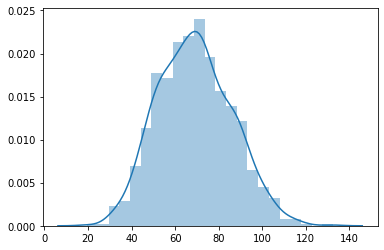

In [62]:
# plot cloudy distibution for 1000 sampling
data = [find_weather()[1] for i in range(1000)]
sns.distplot(data)

In [63]:
sample_trace = trace(find_weather).get_trace()
sample_trace.nodes

OrderedDict([('_INPUT',
              {'args': (), 'kwargs': {}, 'name': '_INPUT', 'type': 'args'}),
             ('weather',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Bernoulli(probs: 0.30000001192092896),
               'infer': {},
               'is_observed': False,
               'kwargs': {},
               'mask': None,
               'name': 'weather',
               'scale': 1.0,
               'stop': False,
               'type': 'sample',
               'value': tensor(1.)}),
             ('temp',
              {'args': (),
               'cond_indep_stack': (),
               'continuation': None,
               'done': True,
               'fn': Normal(loc: 55.0, scale: 10.0),
               'infer': {},
               'is_observed': False,
               'kwargs': {},
               'mask': None,
               'name': 'temp',
               'scale': 1.0,
     

In [68]:
sample_trace.log_prob_sum().exp()

tensor(0.0032)

## If I observe a temperature of 70 degrees, how likely is it to be cloudy? 

In [0]:
def find_weather(obs_temp):
  
  # sample 0 or 1 from a bernouli distribution
  weather = pyro.sample('weather', pyro.distributions.Bernoulli(0.3))
  
  # convert 0 or 1 to cloudy or sunny
  weather = 'cloudy' if weather.item() == 1.0 else 'sunny'
  
  # subset corresponding mean temp out of a dictionary
  mean_temp = {'cloudy': 55.0, 'sunny':75.0}[weather]
  
  var_temp =  {'cloudy': 10.0, 'sunny': 15.0}[weather]
 
  # sample from a normal distribution using the above mean and var
  temp = pyro.sample('temp',
                     pyro.distributions.Normal(mean_temp, var_temp),
                     obs = obs_temp)
  
  # return the weather and temp
  return weather, temp

In [51]:
# for observed temp = 70, do simulation 1000 times
obs_temp = 70.
data = [find_weather(obs_temp) for i in range(1000)]
#data

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at temp
  RuntimeWarning)


In [52]:
# get the table of times cloudy and sunny appears
df = pd.DataFrame(data, columns=('cloudy', 'sunny'))
tab = df.groupby(['cloudy', 'sunny']).size()
print(tab)

cloudy  sunny
cloudy  70.0     300
sunny   70.0     700
dtype: int64


In [53]:
# Get how likey it is to be cloudy
likely_cloudy = tab[0]/(tab[0] + tab[1])
likely_cloudy

0.3

The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data. 

Pyro separate the expression of conditioning from its evaluation via inference, making it possible to write a model once and condition it on many different observations. Pyro supports constraining a model’s internal sample statements to be equal to a given set of observations.

# log probabilities

What is the difference between a sample from a normal distribution, log probability of that sample, log probability exp of that sample


In [136]:
normal = dist.Normal(0,1)
print(normal)

sample = normal.sample()
print(sample)

sample = normal.sample(sample_shape=[3,4,5])
print(sample)


Normal(loc: 0.0, scale: 1.0)
tensor(-0.7856)
tensor([[[-1.0310, -0.2372, -0.2939, -0.0345, -1.2909],
         [ 0.5041, -0.2480, -2.2423,  0.6651,  0.0460],
         [ 0.0063,  1.5112,  0.8163, -0.2369, -0.5550],
         [-0.5904,  0.1580,  0.1481,  0.1842, -1.4677]],

        [[-0.5815, -1.1745,  0.5043, -0.2988,  0.7409],
         [-1.1260,  0.3113, -1.2979, -0.6521, -0.8878],
         [ 0.1813,  0.7919, -1.3477,  1.1076,  0.8875],
         [-1.1023, -0.0266,  0.6935,  0.4347,  0.8148]],

        [[-0.6296,  0.7037,  1.6643,  0.7298, -0.5734],
         [ 0.3999,  0.0161,  0.7690, -0.8167,  0.6825],
         [-1.2659, -0.5452,  0.2551,  0.1201,  0.2503],
         [ 0.9352, -0.7729, -1.1063,  0.4798,  1.2707]]])


In [139]:
normal.log_prob(sample)

tensor([[[-1.4504, -0.9471, -0.9621, -0.9195, -1.7521],
         [-1.0460, -0.9497, -3.4328, -1.1401, -0.9200],
         [-0.9190, -2.0609, -1.2521, -0.9470, -1.0730],
         [-1.0932, -0.9314, -0.9299, -0.9359, -1.9961]],

        [[-1.0880, -1.6087, -1.0461, -0.9636, -1.1934],
         [-1.5529, -0.9674, -1.7612, -1.1316, -1.3130],
         [-0.9354, -1.2325, -1.8271, -1.5324, -1.3127],
         [-1.5265, -0.9193, -1.1594, -1.0134, -1.2509]],

        [[-1.1171, -1.1666, -2.3039, -1.1852, -1.0833],
         [-0.9989, -0.9191, -1.2146, -1.2524, -1.1518],
         [-1.7202, -1.0675, -0.9515, -0.9262, -0.9503],
         [-1.3563, -1.2176, -1.5309, -1.0340, -1.7263]]])

In [140]:
normal.log_prob(sample).exp()

tensor([[[0.2345, 0.3879, 0.3821, 0.3987, 0.1734],
         [0.3513, 0.3869, 0.0323, 0.3198, 0.3985],
         [0.3989, 0.1273, 0.2859, 0.3879, 0.3420],
         [0.3351, 0.3940, 0.3946, 0.3922, 0.1359]],

        [[0.3369, 0.2002, 0.3513, 0.3815, 0.3032],
         [0.2116, 0.3801, 0.1718, 0.3225, 0.2690],
         [0.3924, 0.2916, 0.1609, 0.2160, 0.2691],
         [0.2173, 0.3988, 0.3137, 0.3630, 0.2863]],

        [[0.3272, 0.3114, 0.0999, 0.3057, 0.3385],
         [0.3683, 0.3989, 0.2968, 0.2858, 0.3161],
         [0.1790, 0.3439, 0.3862, 0.3961, 0.3866],
         [0.2576, 0.2959, 0.2163, 0.3556, 0.1779]]])

Multiple distributions can be embedded in single object, as shown in this example, where three Normal distributions with different means and same scale are defined in a single object.

In [146]:
# 3 normal distributions with mean different std same

normal = dist.Normal(torch.tensor([1.,2.,3.]),1.)
print(normal)

# If you sample from such a distribution you get 3 samples, each from 3 of the distributions
print(normal.sample())

print(normal.log_prob(normal.sample()))

print(normal.log_prob(normal.sample()).exp())

Normal(loc: torch.Size([3]), scale: torch.Size([3]))
tensor([1.7538, 3.1476, 3.0993])
tensor([-3.0362, -1.0743, -1.8386])
tensor([0.2408, 0.3551, 0.2698])


# Introduction to conditioning
 

Attempting the same question of weather model using conditionaing:
If I observe a temperature of 70 degrees, how likely is it to be cloudy?

Pyro provides the function pyro.condition to allow us to constrain the values of sample statements. pyro.condition is a higher-order function that takes a model and a dictionary of observations and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements:

# Weather model: Conditioning example 1

In [72]:
# Find the probability of being cloudy and temperature equal to 60
# Model functions
def find_weather():
  # sample 0 or 1 from a bernouli distribution
  weather = pyro.sample('weather', pyro.distributions.Bernoulli(0.3))
  
  # convert 0 or 1 to cloudy or sunny
  weather = 'cloudy' if weather.item() == 1.0 else 'sunny'
  
  # subset corresponding mean temp out of a dictionary
  mean_temp = {'cloudy': 55.0, 'sunny':75.0}[weather]
  
  var_temp =  {'cloudy': 10.0, 'sunny': 15.0}[weather]
  
  # sample from a normal distribution using the above mean and var
  temp = pyro.sample('temp',
                     pyro.distributions.Normal(mean_temp, var_temp))
  
  # return the weather and temp
  return weather, temp.item()


trace(cond_model).get_trace().log_prob_sum().exp()


# Conditioning functions
def weather_model(weather, temp):
  cond_model = condition(find_weather, {
                  "weather": weather,
                  "temp": temp
              })
  
  output = trace(cond_model).get_trace().log_prob_sum().exp()
  
  # Perform importance sampling
  #posterior = pyro.infer.Importance(cond_model, num_samples = 1000)
  
  #marginal = pyro.infer.EmpiricalMarginal(posterior.run())
  
  return output.item()

weather = torch.tensor(1.)
temp = torch.tensor(60.0)

weather_model(weather, temp)


0.010561957955360413

# Scale model: Conditioning example 2

**Talks about a noisy scale, and model that as a random normal, with its mean being a sample from a normal around our guess.** The scale output is generated following a normal distribution around the real value, which is weight. Saying that this real value was drawn from our prior is simply a way to penalize unlikely observations

Suppose we are trying to figure out how much something weighs, but the scale we’re using is unreliable and gives slightly different answers every time we weigh the same object. We could try to compensate for this variability by integrating the noisy measurement information with a guess based on some prior knowledge about the object, like its density or material properties. 

1. We will build a model that takes input as a guess weight and to have some stochasticity, we will use this as the mean and draw a sample from a normal distribution. Using this sample, we will again use this as the mean and sample from another normal distribution, to be as close to our guess. Imagine this to be a model, it has nothing to do with bayesian statistics. Just a simple stochastic model that gives different measures everytime we measure. 

2. As a next step, we want to have the same object weighed multiple times to estimate the exact value of the object. So we will use condition to input 9.5 as the guess all the time and get back different measurements as output. 

3. Once it is done, we will use this model as the MODEL and create a guide function to approximate to this distribution of object weights. Imagine that we do not know how this distribution looks like. 

The guide is made in such a way that it has the parameters mu and sigma to be learned. a is close to our "guess", which we provided inside the model. b is the approximate standard deviation we think it is. Further, we call the guide function and get a normally distributed sample. You have to make sure at this point that the names of the sampled parameters "weight" needs to be same in both model and guide functions. 

Once all these steps are done, we will use stochastic variational inference. 

In [0]:
def scale(guess):
  weight = pyro.sample('weight', pyro.distributions.Normal(guess, 1.0))
  return pyro.sample('measurement', pyro.distributions.Normal(weight, 0.75))


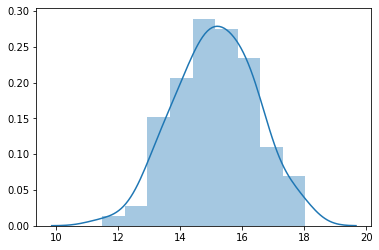

In [28]:
generate_data = [scale(15).numpy() for i in range(100)]
sns.distplot(generate_data)

You can define condition as a statement or a function as shown .below in cells

In [0]:
# Conditioned scale 
conditioned_scale = condition(scale, data = {"measurement": 9.50})

In [0]:
# Conditioned scale as a function
def deferred_conditioned_scale(measurement, guess):
  return condition(scale, data = {"measurement": measurement})(guess) #(guess) because scale takes parameter


In [77]:
deferred_conditioned_scale(9.5, 8.5)

9.5

In [130]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement

scale(14.)

conditioned_scale = pyro.condition(scale,{"measurement": torch.tensor(14.)})

trace(conditioned_scale).get_trace(torch.tensor(14.0)).log_prob_sum().exp()


tensor(0.1402)

In [132]:
# Set the prior and infer the posterior. We will use the Hamiltonian Monte Carlo (HMC) inference algorithm with the no U-turn sampler (NUTS), like you would in a language like Stan.
from pyro.infer import NUTS, MCMC, EmpiricalMarginal

guess_prior = torch.tensor(13.)

nuts_kernel = NUTS(conditioned_scale, adapt_step_size=True)
posterior = MCMC(nuts_kernel, 
                 num_samples=1000, 
                 warmup_steps=300).run(guess_prior)
marginal = EmpiricalMarginal(posterior, "weight")

plt.hist([marginal().item() for _ in range(1000)],)
plt.title("P(weight | measurement = 14)")
plt.xlabel("Weight")
plt.ylabel("#")
print(posterior)

Sample: 100%|██████████| 1300/1300 [00:07, 176.55it/s, step size=1.05e+00, acc. prob=0.935]

None


# Flexible Approximate Inference With Guide Functions

## Estimate the distribution over weight given "guess" and "measurement data".


Inference algorithms in Pyro, such as pyro.infer.SVI, allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions. 

Posterior distribution can be modeled using an approximate distribution, and then distorting it's parameters to approximate the target distribution. We can call this approximate distribution "GUIDE" in pyro. 

**To make inference in Pyro over a given model we need to define a guide, this guide has the same signature than its counterpart model. And the guide must provide samples for those variables of the model which are not observed using again the pyro.sample construct. Guides are also parametrized using Pyro's parameters (pyro.param), so the variational inference algorithm will optimize these parameters.**


Guide must satisfy these conditions to to be valid approximations for a particular model.

1. All unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. 

2. The guide has the same input signature as the model (i.e., takes the same arguments)

**Guide functions can serve as programmable, data-dependent proposal distributions for** importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, importance sampling, MCMC, and stochastic variational inference are implemented in Pyro, and we plan to add other algorithms in the future.

Although the precise meaning of the guide is different across different inference algorithms, the guide function should generally be chosen so that, in principle, it is flexible enough to closely approximate the distribution over all unobserved sample statements in the model.

In the case of scale, **it turns out that the true posterior distribution over weight given guess and measurement is actually Normal(9.14,0.6)**. As the model is quite simple, we are able to determine our posterior distribution of interest analytically (for derivation


Ref: 
1. https://github.com/probabilisticai/probai-2019
2. pyro.ai


In [0]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess)) # I guess it is guess
    b = pyro.param("b", torch.tensor(1.))    # standard deviation
    return pyro.sample("weight",
                       pyro.distributions.Normal(a, torch.abs(b)))  

As an aside, note that in scale_parametrized_guide, we had to apply torch.abs to parameter b because the standard deviation of a normal distribution has to be positive; similar restrictions also apply to parameters of many other distributions. The PyTorch distributions library, which Pyro is built on, includes a constraints module for enforcing such restrictions, and applying constraints to Pyro parameters is as easy as passing the relevant constraint object to pyro.param:

In [0]:
def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight",
                       pyro.distributions.Normal(a, b))  # no more torch.abs

Pyro is built to enable stochastic variational inference, a powerful and widely applicable class of variational inference algorithms with three key characteristics:

Parameters are always real-valued tensors

We compute Monte Carlo estimates of a loss function from samples of execution histories of the model and guide

We use stochastic gradient descent to search for the optimal parameters.

Combining stochastic gradient descent with PyTorch’s GPU-accelerated tensor math and automatic differentiation allows us to scale variational inference to very high-dimensional parameter spaces and massive datasets.

a =  9.149458885192871
b=  0.5678160190582275


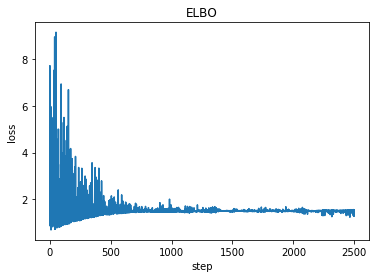

In [0]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model = conditioned_scale,
                     guide = scale_parametrized_guide_constrained,
                     optim = pyro.optim.SGD({"lr":0.001,
                                             "momentum": 0.1}),
                     loss = pyro.infer.Trace_ELBO())

losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
  losses.append(svi.step(guess))
  a.append(pyro.param("a").item())
  b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print('a = ', pyro.param("a").item())
print('b= ', pyro.param("b").item())

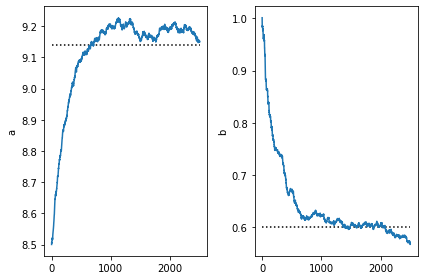

In [0]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# Let's look at everything together

a=  9.150297164916992
b=  0.5983615517616272


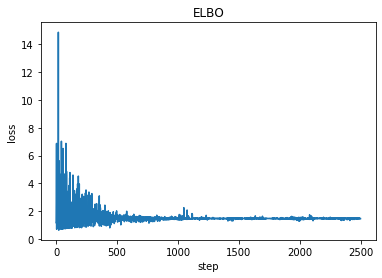

In [134]:
'''
Estimate the distribution over weight given "guess" and "measurement data"
1. Input: guess weight of the object
2. Measurement: Measured weight of the object
3. Ouput: Estimate the distribution of weight of the object

We will start with guess as the mean(parameter a) and 1(parameter b) as the standard deviation.
Using a sampling or SVI method, we can compute the distribution of weight as well as the original value of the parameters a and b
'''


# Model part
# There is a messy scale model that outputs a normal sample using "a sample from the normal distribution centered around our guess"
def scale(guess):
  weight = pyro.sample('weight',
                       pyro.distributions.Normal(guess, 1.0))
  measurement = pyro.sample('measurement',
                            pyro.distributions.Normal(weight,
                                                      0.75))
  return measurement


# conditioning part
# We condition our model to always measure a value 9.5
conditioned_model = condition(scale, {'measurement':9.5})

# Guide
# In the guide function we initialize two parameters a and b.
# the b (std) needs to be positive therefore we take the toch.abs(b)
def guide(guess):
  a = pyro.param("a", torch.tensor(guess))
  b = pyro.param("b", torch.tensor(1.))
  return pyro.sample("weight",
                     pyro.distributions.Normal(a, torch.abs(b)))

# Approximation
# input guess of weight
guess = 8.5

# clear parameter sore
pyro.clear_param_store()

# Run variational inferece
svi = pyro.infer.SVI(model = conditioned_model,
                     guide = guide,
                     optim = pyro.optim.SGD({"lr":0.001,
                                             "momentum": 0.1}),
                     loss = pyro.infer.Trace_ELBO())

# Approximation steps
losses, a, b = [], [], []
num_steps = 2500

for t in range(num_steps):
  losses.append(svi.step(guess))
  a.append(pyro.param("a").item())
  b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print("a= ", pyro.param("a").item())
print("b= ", pyro.param("b").item())

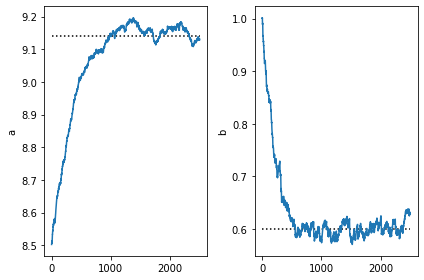

In [0]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

Just like the model, the guide is encoded as a stochastic function guide() that contains pyro.**sample and pyro.param statements. It does not contain observed data, since the guide needs to be a properly normalized distribution.** Note that Pyro enforces that model() and guide() have the same call signature, i.e. both callables should take the same arguments.

Since the guide is an approximation to the posterior pθmax(z|x), the guide needs to provide a valid joint probability density over all the latent random variables in the model. Recall that when random variables are specified in Pyro with the primitive statement pyro.sample() the first argument denotes the name of the random variable. These names will be used to align the random variables in the model and guide. To be very explicit, if the model contains a random variable z_1

Once we’ve specified a guide (we give some explicit examples below), we’re ready to proceed to inference. Learning will be setup as an optimization problem where each iteration of training takes a step in θ−ϕ space that moves the guide closer to the exact posterior. To do this we need to define an appropriate objective function.

# SVI Part1: Coin toss model

We finish with a simple example. You’ve been given a two-sided coin. You want to determine whether the coin is fair or not, i.e. whether it falls heads or tails with the same frequency. You have a prior belief about the likely fairness of the coin based on two observations:

it’s a standard quarter issued by the US Mint

it’s a bit banged up from years of use

So while you expect the coin to have been quite fair when it was first produced, you allow for its fairness to have since deviated from a perfect 1:1 ratio. So you wouldn’t be surprised if it turned out that the coin preferred heads over tails at a ratio of 11:10. By contrast you would be very surprised if it turned out that the coin preferred heads over tails at a ratio of **5:1—it’s not that banged up.**


To turn this into a probabilistic model we encode heads and tails as 1s and 0s. We encode the fairness of the coin as a real number f, where f satisfies f∈[0.0,1.0] and f=0.50 corresponds to a perfectly fair coin. Our prior belief about f will be encoded by a beta distribution, specifically Beta(10,10), which is a symmetric probability distribution on the interval [0.0,1.0] that is peaked at f=0.5.

In [0]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.2.0')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.535 +- 0.089


# Sleep model
http://willcrichton.net/notes/probabilistic-programming-under-the-hood/

In [43]:
def sleep_model():
    
    # Very likely to feel lazy
    feeling_lazy = pyro.sample("feeling_lazy", dist.Bernoulli(0.9))
    
    if feeling_lazy:
        
        # Only going to (possibly) ignore my alarm if I'm feeling lazy
        ignore_alarm = pyro.sample("ignore_alarm", dist.Bernoulli(0.8))
        
        # Will sleep more if I ignore my alarm
        amount_slept = pyro.sample("amount_slept",
                              dist.Normal(8 + 2 * ignore_alarm, 1))
    else:
        amount_slept = pyro.sample("amount_slept", dist.Normal(6, 1))
    
    return amount_slept

print(sleep_model())

print(sleep_model()) 

print(sleep_model()) 

tensor(6.1913)
tensor(9.2602)
tensor(10.2821)


# What is trace ?

Ref: https://github.com/pyro-ppl/pyro/blob/dev/pyro/poutine/trace_messenger.py

Return a handler that records the inputs and outputs of primitive calls
and their dependencies.

I think trace calculates the joint or conditional probability of an event happening when the model is asked to make decisions backward(Something close like this)

Trace traces backs to the beginning of a model from the output and gets all parameter values of the model


    
    Consider the following Pyro program:
        >>> def model(x):
        ...     s = pyro.param("s", torch.tensor(0.5))
        ...     z = pyro.sample("z", dist.Normal(x, s))
        ...     return z ** 2
    We can record its execution using ``trace``
    and use the resulting data structure to compute the log-joint probability
    of all of the sample sites in the execution or extract all parameters.
        >>> trace = pyro.poutine.trace(model).get_trace(0.0)
        >>> logp = trace.log_prob_sum()
        >>> params = [trace.nodes[name]["value"].unconstrained() for name in trace.param_nodes]

In [1]:
def model(x):
    s = pyro.param("s", torch.tensor(0.5))
    z = pyro.sample("z", dist.Normal(x, s))
    return z ** 2

trace = pyro.poutine.trace(model).get_trace(5.0)
print(trace)
logp = trace.log_prob_sum()
print(logp)
params = [trace.nodes[name]["value"].unconstrained() for name in trace.param_nodes]
print(params)

NameError: ignored

In [0]:
# Runs the sleep model once and collects a trace
tr = trace(sleep_model).get_trace()

## Joint probability of a sample: what is the probability that feeling_lazy = 1, ignore_alarm = 0, amount_slept = 10?

In [60]:
cond_model = condition(sleep_model, {
    "feeling_lazy": torch.tensor(1.),
    "ignore_alarm": torch.tensor(0.),
    "amount_slept": torch.tensor(10.)
})

trace(cond_model).get_trace().log_prob_sum().exp() # 0.0097

tensor(0.0097)

Here, condition means “force the sample to return the provided value, and compute the trace probability as if that value was sampled.” So for example, forcing feeling_lazy to 1 means the trace starts with probability 0.9. 

we can look at the marginal distribution over each variable:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ca65240f0>,
      dtype=object)

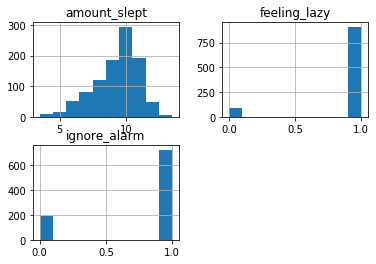

In [62]:
traces = []

for _ in range(1000):
  tr = trace(sleep_model).get_trace()

  values = {
      name: props['value'].item()
      for(name, props) in tr.nodes.items()
      if props['type'] == 'sample'
  }
  traces.append(values)

pd.DataFrame(traces).hist()

## Sampling conditional distributions

Here’s a few more questions we might want to answer.

Given I slept 6 hours, what is the probability I was feeling lazy?
What is the probability of me sleeping exactly 7.65 hours?

These are conditional probability questions, meaning they ask: given a particular value of some of the random variables, what are the likely values for the other random variables? The probability folk tend to call these “observed” and “latent” variables (often denoted by X and Z), respectively. A common use case for generative models is that the generated object is the thing you observe in the real world (like an image), and you want to guess the values of unobserved variables given that observation (like whether the image is a cat or a dog).

## Variational Inference 1: Autodifferentiation

Since Pyro’s stake in the ground is on variational inference, let’s explore all the mechanics underneath it. For starters, we need to understand autodifferentiation, gradients, and backpropagation in PyTorch. Let’s say I have an extremely simple model that just samples a normal distribution with fixed parameters:

In [0]:
norm = dist.Normal(0, 1)
x = pyro.sample("x", norm)

However, let’s say I know the value of x = 5 and I want to find a mean μ to the normal distribution that maximizes the probability of seeing that x. For that, we can use a parameter:

In [0]:
mu = param("mu", torch.tensor(0.))

norm = dist.Normal(mu, 1)

x = pyro.sample("x", norm)


A parameter is a persistent value linked to a string name with an initial value here of 0. It is torch tensor with requires_grad = True. Our goal is to update mu such that the probability of the value 5 under the normal distribution norm is maximized. Pytorch makes that quite easy. 

In [67]:
prob = norm.log_prob(5)
print(prob, prob.exp())

prob.backward()

print(mu)
print(mu.grad)

mu.data += mu.grad
print(dist.Normal(mu, 1).log_prob(5))

tensor(-13.4189, grad_fn=<SubBackward0>) tensor(1.4867e-06, grad_fn=<ExpBackward>)
tensor(0., requires_grad=True)
tensor(5.)
tensor(-0.9189, grad_fn=<SubBackward0>)


In [0]:
# Learning from a bunch of observations

In this case, we assume we have a bunch of observations about the temperature at different time steps. In this case, following a probabilistic modelling approach, we define a bunch of random variables, one for each observation, using a standard for-loop.
